Purpose: Run set operations to find core genes using BioProject-corrected TPM (both for all samples and for photosynthetic tissues only).<br>
Author: Anna Pardo<br>
Date initiated: Mar. 7, 2024

In [1]:
import numpy as np
import pandas as pd
from venn import venn
import matplotlib.pyplot as plt
import math

In [2]:
# load corrected TPM matrices
bpcor_all_tpm = pd.read_csv("../../data/BPcombat_logTPM_forRF_1-Mar-2024.tsv",sep="\t",header="infer")
bpcor_psyn_tpm = pd.read_csv("../../data/BPcombat_logTPM_psyn_tissues_forRF_1-Mar-2024.tsv",sep="\t",header="infer")

In [3]:
# replace DroughtRepeat with Drought
bpcor_all_tpm["Treatment"].mask(bpcor_all_tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)
bpcor_psyn_tpm["Treatment"].mask(bpcor_psyn_tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [4]:
# temporarily save Sample, BioProject, & Treatment columns
bpall_md = bpcor_all_tpm[["Sample","BioProject","Treatment"]]
bpsyn_md = bpcor_psyn_tpm[["Sample","BioProject","Treatment"]]

In [5]:
# set Sample as index & drop BioProject and Treatment columns
bpall_log = bpcor_all_tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1)
bpsyn_log = bpcor_psyn_tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1)

In [6]:
# undo the log2 transformation
bpall = bpall_log.apply(lambda x: (2**x)-1)

In [7]:
bpsyn = bpsyn_log.apply(lambda x: (2**x)-1)

In [8]:
# make a function for calculating TN-ratio (https://www.biorxiv.org/content/10.1101/2023.04.17.537107v2.full)
def tn_ratio(stress_tpm,control_tpm):
    return (stress_tpm+1)/(control_tpm+1)

In [9]:
# write a function that will do all that for a given experiment
def experiment_tn(bioproject,tpmdf):
    sbp = tpmdf[tpmdf["BioProject"]==bioproject]
    sbp = sbp.set_index("Sample").drop("BioProject",axis=1)
    means = sbp.groupby("Treatment").mean().transpose()
    for i in means.columns:
        if i != "Control":
            means[i+"_TN"] = tn_ratio(means[i],means["Control"])
    return means

In [10]:
# add BioProject & Treatment columns back
bpall = bpall.reset_index().merge(bpall_md)
bpsyn = bpsyn.reset_index().merge(bpsyn_md)

In [20]:
# make the calculation for all the experiments and output a dictionary of dataframes
bpalldict = {}
for b in bpall["BioProject"].unique():
    bpalldict[b] = experiment_tn(b,bpall)

In [21]:
bpsyndict = {}
for b in bpsyn["BioProject"].unique():
    bpsyndict[b] = experiment_tn(b,bpsyn)

In [23]:
for k,v in bpalldict.items():
    # add a BioProject column
    v["BioProject"] = k
    # reset the index
    v.reset_index(inplace=True)
    v.rename(columns={"index":"GeneID"},inplace=True)

In [25]:
for k,v in bpsyndict.items():
    # add a BioProject column
    v["BioProject"] = k
    # reset the index
    v.reset_index(inplace=True)
    v.rename(columns={"index":"GeneID"},inplace=True)

In [32]:
## write a function to get the dictionaries of up- & downregulated genes
def de_reg_dicts(dfdict):
    # go through all the dictionary entries and make dictionaries for each stressor
    cold = {}
    ln = {}
    heat = {}
    drought = {}
    flood = {}
    salt = {}

    for b in dfdict.keys():
        df = dfdict[b]
        if "Cold" in df.columns:
            cold[b] = df
        if "Low_Nitrogen" in df.columns:
            ln[b] = df
        if "Heat" in df.columns:
            heat[b] = df
        if "Drought" in df.columns:
            drought[b] = df
        if "Flooding" in df.columns:
            flood[b] = df
        if "Salt" in df.columns:
            salt[b] = df
            
    # make a dict of the stress dictionaries
    stressdict = {"Cold":cold,"Low_Nitrogen":ln,"Heat":heat,"Drought":drought,"Flooding":flood,"Salt":salt}
    
    upgenes = {}
    downgenes = {}
    for k,v in stressdict.items():
        upgenes[k] = {}
        downgenes[k] = {}
        for i in v.keys():
            df = v[i]
            # subset dataframe to only the genes that have TN-ratio <0.5 or >2
            down = df[df[k+"_TN"]<0.5]
            up = df[df[k+"_TN"]>2]
            upgenes[k][i] = set(up["GeneID"])
            downgenes[k][i] = set(down["GeneID"])
            
    return {"Up":upgenes,"Down":downgenes}

In [33]:
bpallreg = de_reg_dicts(bpalldict)

In [35]:
bpsynreg = de_reg_dicts(bpsyndict)

In [38]:
# for upgenes and downgenes: compress into dictionaries of sets by stressor, not by stressor then BioProject
def reform_dict(regdict):
    outdict = {}
    for r,d in regdict.items():
        outdict[r] = {}
        for s in d.keys():
            subdict = regdict[r][s]
            # make a set with the contents of the sets
            ## first make a list
            sgenes = []
            for k in subdict.keys():
                for i in subdict[k]:
                    sgenes.append(i)
            outdict[r][s] = set(sgenes)
            
    return outdict

In [39]:
all_reform = reform_dict(bpallreg)

In [40]:
psyn_reform = reform_dict(bpsynreg)

Text(0.5, 0.98, 'Common and unique genes among stressors in maize (all data, corrected by BioProject)')

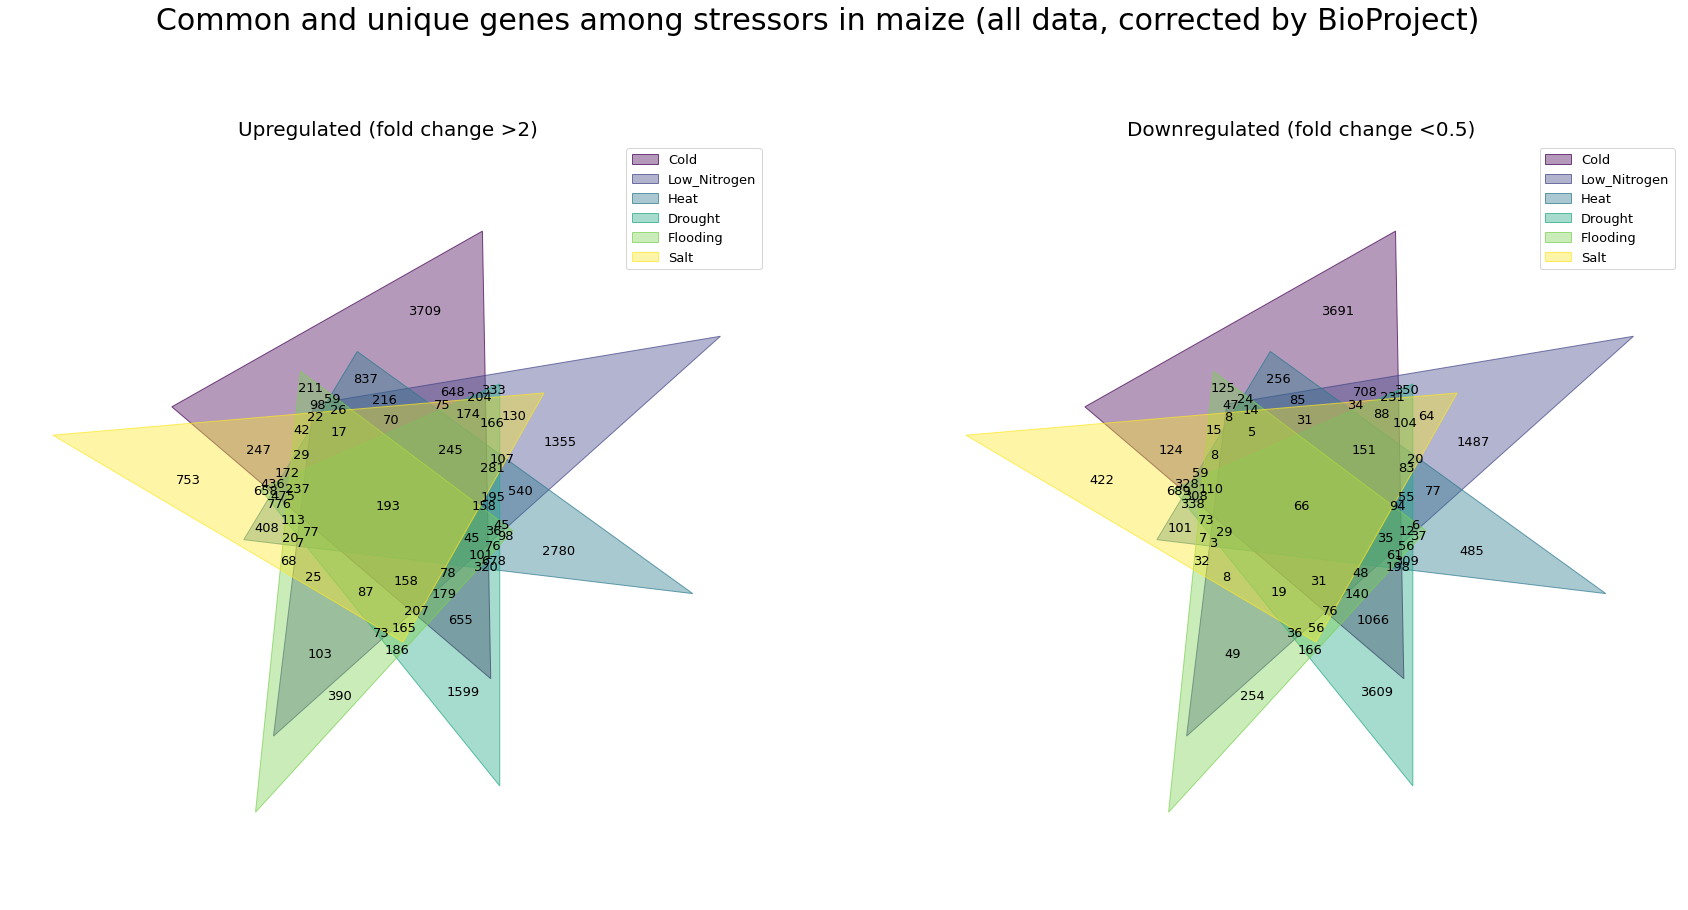

In [41]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(all_reform["Up"],ax=ax[0])
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(all_reform["Down"],ax=ax[1])
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize (all data, corrected by BioProject)",fontsize=30)

Text(0.5, 0.98, 'Common and unique genes among stressors in maize (photosynthetic tissues only, corrected by BioProject)')

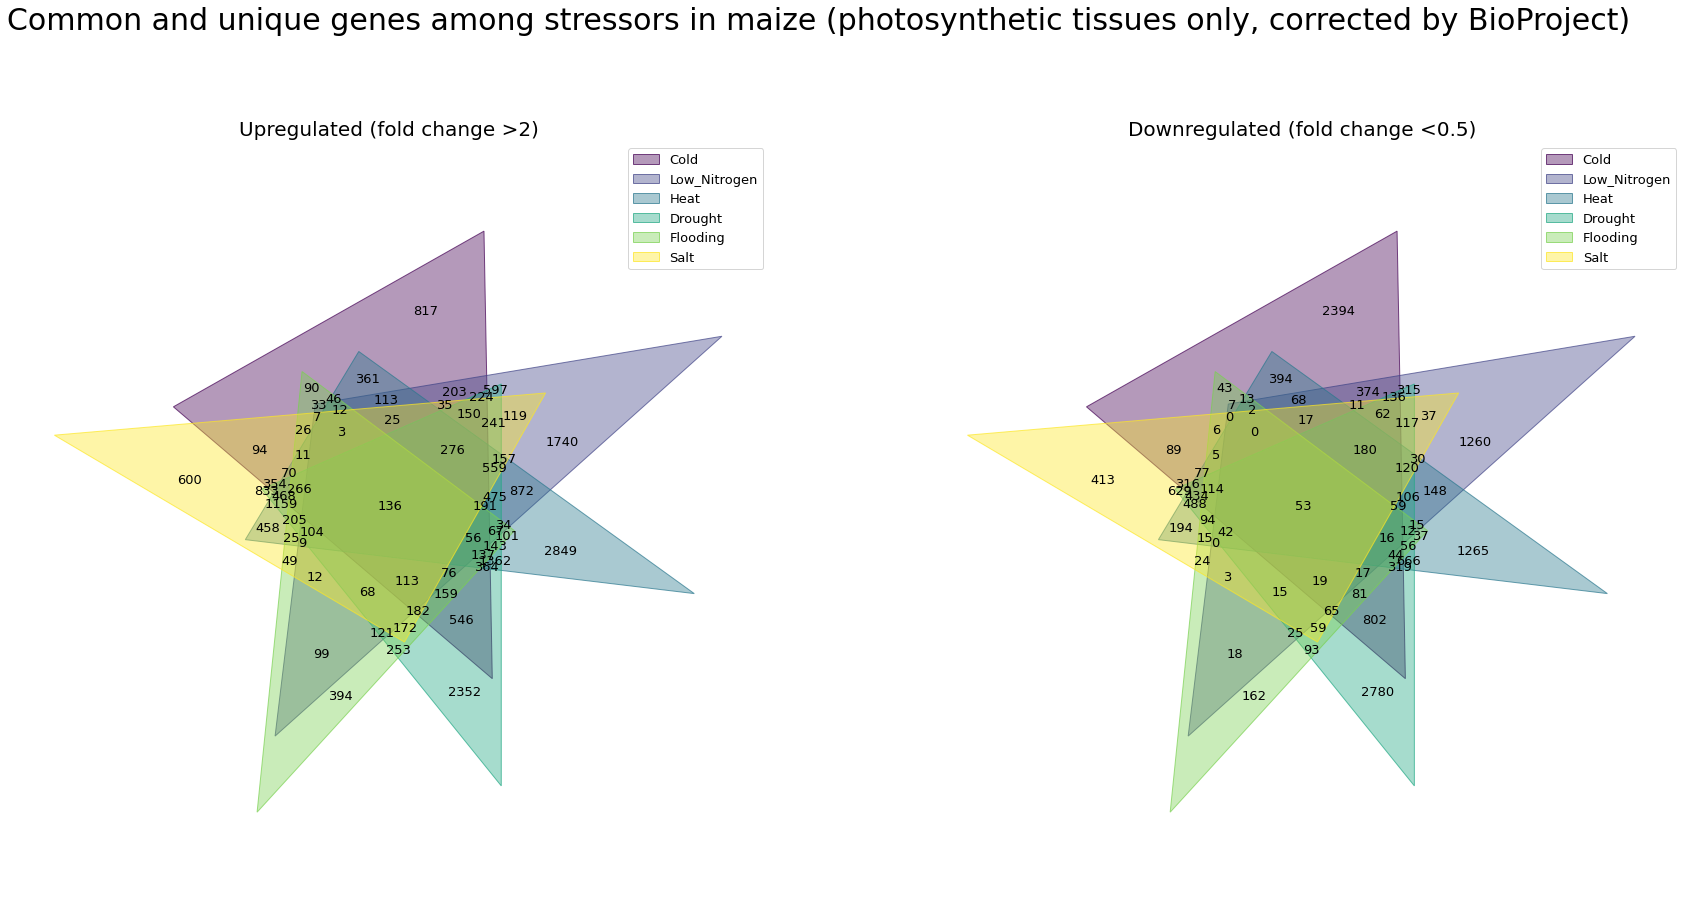

In [42]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(psyn_reform["Up"],ax=ax[0])
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(psyn_reform["Down"],ax=ax[1])
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize (photosynthetic tissues only, corrected by BioProject)",fontsize=30)

Text(0.5, 0.98, 'Common and unique genes among stressors in maize (photosynthetic tissues only, corrected by BioProject)')

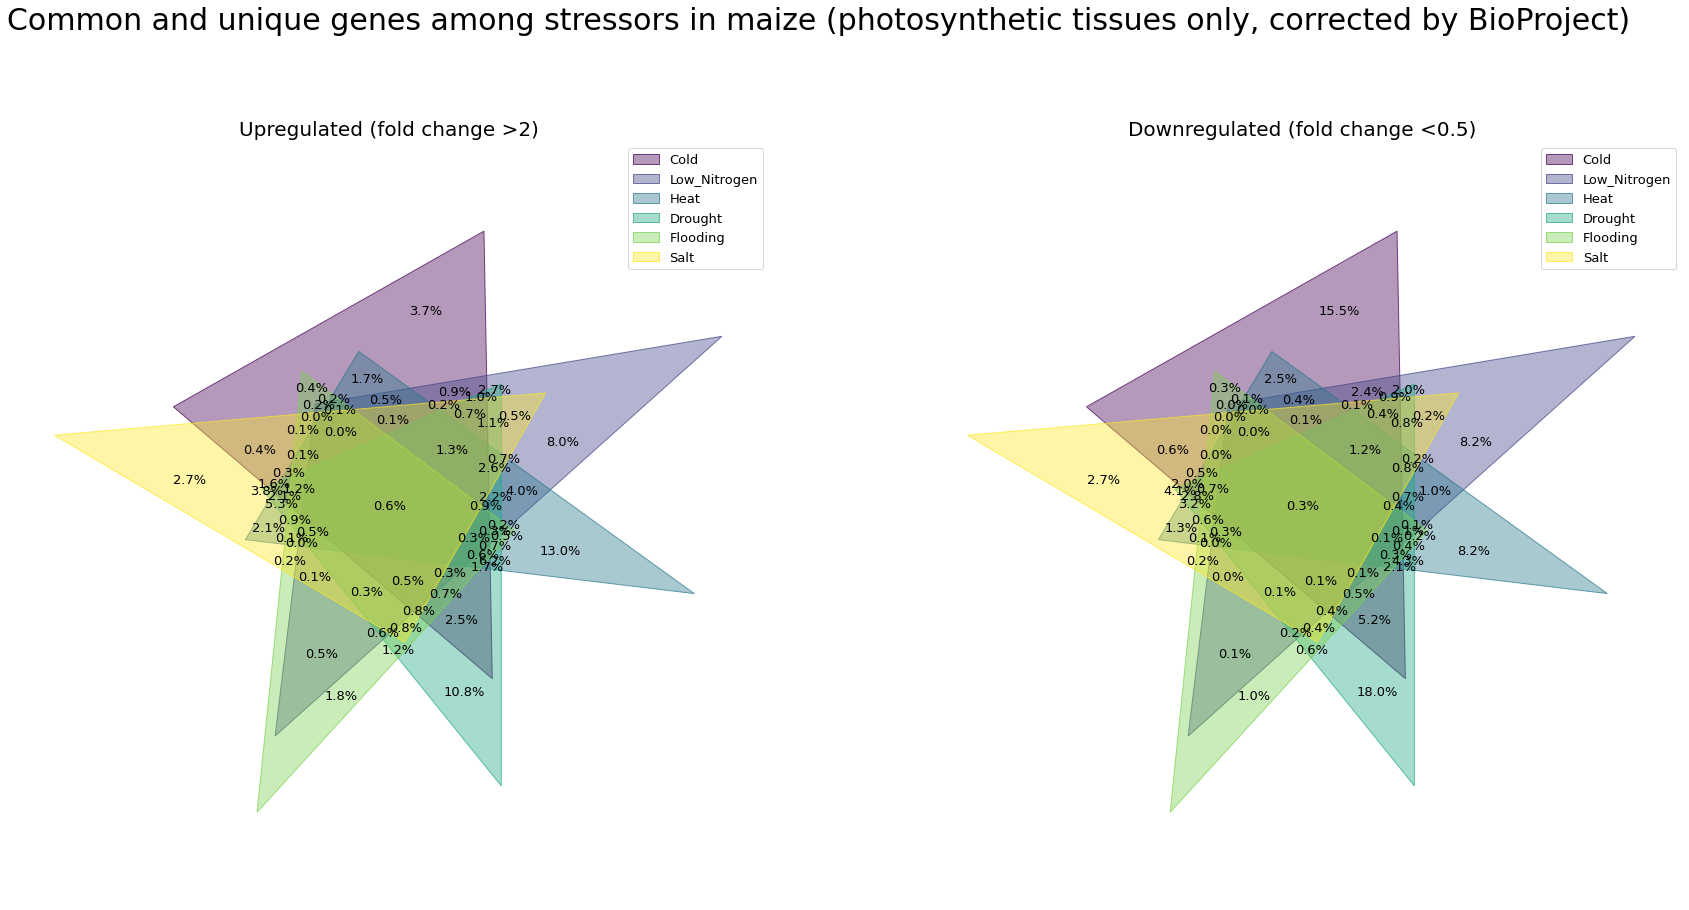

In [44]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(psyn_reform["Up"],ax=ax[0],fmt="{percentage:.1f}%")
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(psyn_reform["Down"],ax=ax[1],fmt="{percentage:.1f}%")
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize (photosynthetic tissues only, corrected by BioProject)",fontsize=30)

Text(0.5, 0.98, 'Common and unique genes among stressors in maize (all data, corrected by BioProject)')

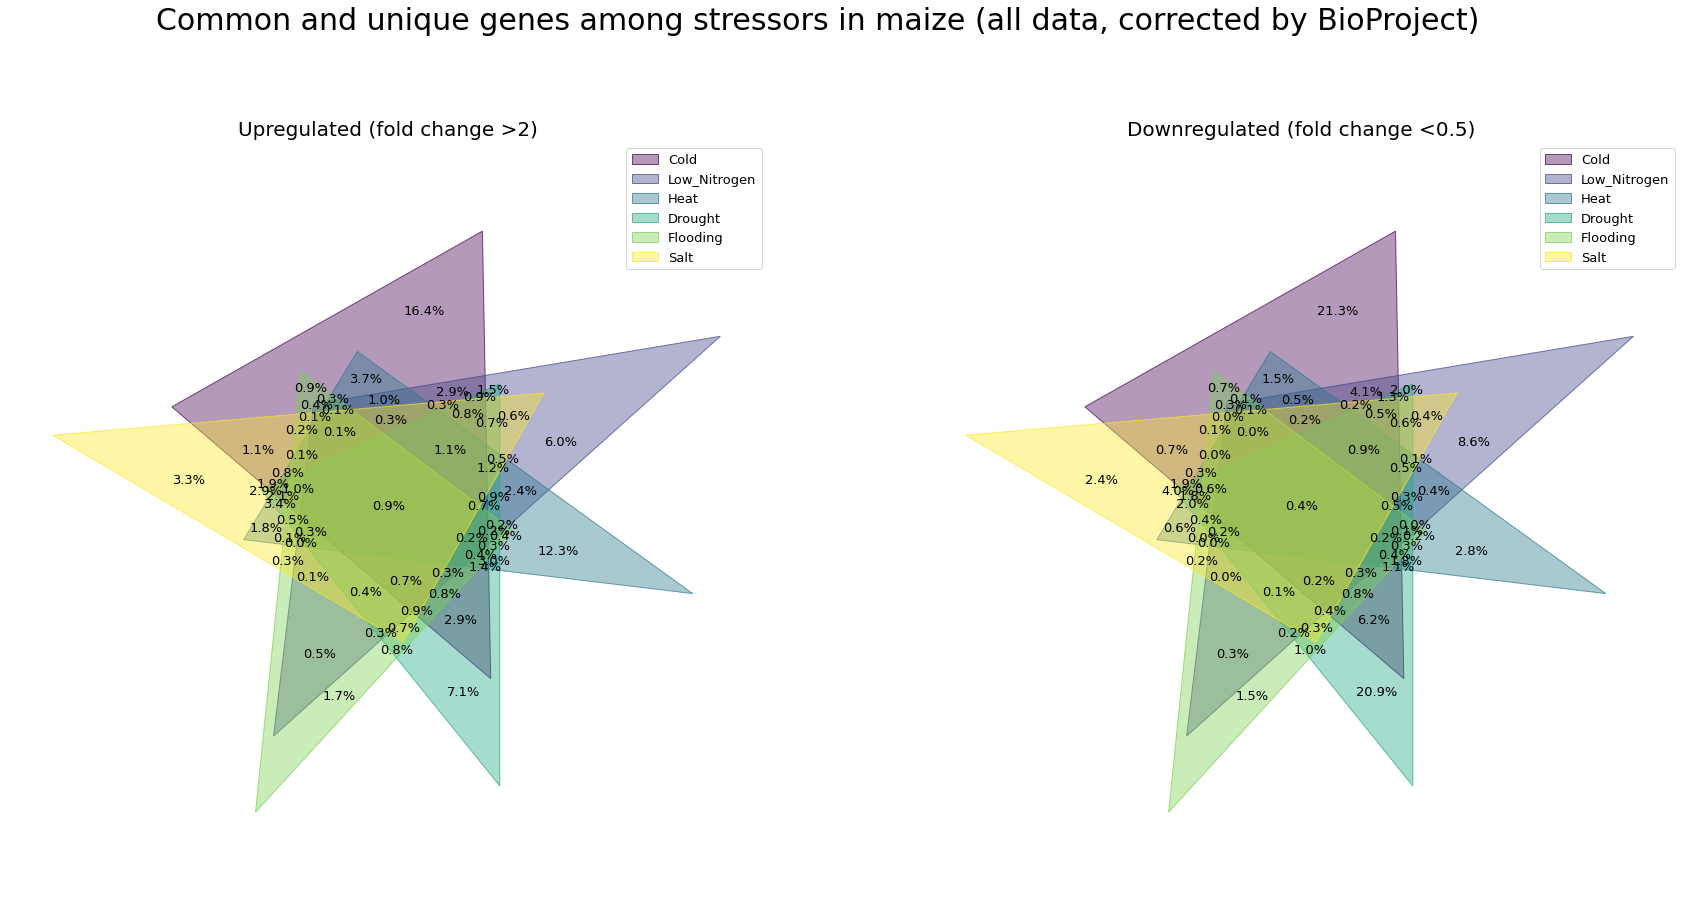

In [46]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(all_reform["Up"],ax=ax[0],fmt="{percentage:.1f}%")
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(all_reform["Down"],ax=ax[1],fmt="{percentage:.1f}%")
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize (all data, corrected by BioProject)",fontsize=30)

In [49]:
# save lists of the core genes
upcore_all = list(set.intersection(*all_reform["Up"].values()))
downcore_all = list(set.intersection(*all_reform["Down"].values()))

upcore_psyn = list(set.intersection(*psyn_reform["Up"].values()))
downcore_psyn = list(set.intersection(*psyn_reform["Down"].values()))

In [50]:
# save as text files
with open("../../data/core_upgenes_fromsets_all_corrBP.txt","w+") as outfile:
    for i in upcore_all:
        outfile.write(i+"\n")

In [51]:
with open("../../data/core_downgenes_fromsets_all_corrBP.txt","w+") as outfile:
    for i in downcore_all:
        outfile.write(i+"\n")

In [52]:
with open("../../data/core_upgenes_fromsets_psyn_corrBP.txt","w+") as outfile:
    for i in upcore_psyn:
        outfile.write(i+"\n")

In [53]:
with open("../../data/core_downgenes_fromsets_psyn_corrBP.txt","w+") as outfile:
    for i in downcore_psyn:
        outfile.write(i+"\n")